In [150]:
import json
import os
import pickle

import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
import torch
from PIL import Image
# from subtask_1_2a import check_format, evaluate_h, _read_gold_and_pred
import subtask_1_2a

# Preparing embeddings and data for classification

In [8]:
CLIP_MODEL_FEATURES = "../extracted_features/ClipVIT_B32"

def read_data(path):
    with open(path, 'rb') as f:
        data = pickle.load(f)
    return data

def get_embeddings(task, set, embeddings_dir=CLIP_MODEL_FEATURES):
    embeddings_dir = embeddings_dir
    for name in os.listdir(embeddings_dir):
        if task + "_" + set in name:
            if "image" in name:
                image_embeddings = read_data(os.path.join(embeddings_dir, name))
                image_embeddings = [embedding[0].numpy() for _, embedding in image_embeddings.items()]
            elif "text" in name:
                text_embeddings = read_data(os.path.join(embeddings_dir, name))
                text_embeddings = [embedding[0].numpy() for _, embedding in text_embeddings.items()]

    return text_embeddings, image_embeddings

def get_raw_data(task, set):
    set = "val" if set == "validation" else set
    file = f"../annotations/subtask{task}/{set}.json"
    data = pd.read_json(file)
    return data

def get_data(task, set):
    text_embeddings, image_embeddings = get_embeddings(task, set)
    raw_data = get_raw_data(task, set)
    raw_data["text_embeddings"] = text_embeddings
    raw_data["image_embeddings"] = image_embeddings

    return raw_data

def to_json(df, file_name):
    """
        Saves result in a valid json format.
    """
    data = []

    for _, row in df.iterrows():
        entry = {
            "id": str(row['id']),
            "text": str(row['text']),
            "labels": row['labels']
        }
        data.append(entry)

    with open(file_name, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, ensure_ascii=False)

In [3]:
data_train = get_data(task="2b", set="train")
data_validation = get_data(task="2b", set="validation")

data_train["concatenated_embeddings"] = data_train.apply(lambda row: np.concatenate((row.text_embeddings, row.image_embeddings)), axis=1)
data_validation["concatenated_embeddings"] = data_validation.apply(lambda row: np.concatenate((row.text_embeddings, row.image_embeddings)), axis=1)

In [4]:
data_train

,id,text,image,label,text_embeddings,image_embeddings,concatenated_embeddings
0,35807,DONALD TRUMP: BARACK\nOBAMA AND JOE BIDEN\nWIL...,prop_meme_6570.png,propagandistic,"[-0.3242, 0.04156, 0.1288, -0.04965, -0.313, -...","[-0.5376, 0.428, -0.404, 0.2576, 0.03836, 0.15...","[-0.3242, 0.04156, 0.1288, -0.04965, -0.313, -..."
1,30562,00\n10% FOR\nTHE BIG GUY\nNANCY'S\nCUT\n@ImMem...,prop_meme_8346.png,propagandistic,"[0.1453, 0.279, -0.07104, 0.2039, -0.1882, 0.3...","[0.4866, 0.3816, 0.4597, 0.1007, -0.2932, -0.5...","[0.1453, 0.279, -0.07104, 0.2039, -0.1882, 0.3..."
2,44163,"To much political posting online\nthese days, ...",prop_meme_24378.png,non_propagandistic,"[-0.0949, 0.01037, -0.3408, -0.01467, -0.3308,...","[-0.1317, -0.2247, -0.2047, 0.02065, 0.1738, -...","[-0.0949, 0.01037, -0.3408, -0.01467, -0.3308,..."
3,24224,I DON'T THINK\nYOU UNDERSTOOD\nWHAT I SAID.\nY...,prop_meme_2594.png,propagandistic,"[0.02841, -0.0127, 0.1814, -0.0631, -0.3118, 0...","[0.1572, -0.2983, 0.2915, -0.249, -0.642, 0.29...","[0.02841, -0.0127, 0.1814, -0.0631, -0.3118, 0..."
4,31611,ⒸSergey Mihailicenko/Anadolu Agency via Getty ...,prop_meme_7654.png,propagandistic,"[-0.01251, -0.3154, -0.1598, -0.362, -0.2141, ...","[-0.4382, 0.4343, -0.1145, 0.2101, 0.2932, -0....","[-0.01251, -0.3154, -0.1598, -0.362, -0.2141, ..."
...,...,...,...,...,...,...,...
1195,24014,Joe Biden\nis transplanting\nHundreds of thous...,prop_meme_4276.png,propagandistic,"[-0.08105, -0.1439, 0.2069, 0.1754, -0.0593, -...","[0.002172, 0.3079, 0.01727, 0.4546, 0.04306, -...","[-0.08105, -0.1439, 0.2069, 0.1754, -0.0593, -..."
1196,31283,THE INDEPENDENT REVIEW BROUGHT ON BY\nREPUBLIC...,prop_meme_7494.png,propagandistic,"[0.1885, 0.1377, 0.2491, -0.05048, -0.2524, 0....","[0.07825, 0.2041, 0.1857, 0.03842, -0.2029, 0....","[0.1885, 0.1377, 0.2491, -0.05048, -0.2524, 0...."
1197,34833,Longtime White House Photographer Pete\nSouza ...,prop_meme_6217.png,propagandistic,"[-0.1749, -0.02106, -0.1366, 0.2104, -0.4033, ...","[-0.3796, 0.7524, 0.1749, 0.05066, 0.3706, 0.0...","[-0.1749, -0.02106, -0.1366, 0.2104, -0.4033, ..."
1198,23378,✔\nThe last time I was here in 2017\nCapitol p...,prop_meme_3748.png,propagandistic,"[0.08234, -0.3438, -0.1277, 0.308, -0.678, -0....","[-0.2086, -0.631, 0.3274, 0.382, -0.6704, 0.13...","[0.08234, -0.3438, -0.1277, 0.308, -0.678, -0...."


In [5]:
# X_train, X_test, Y_train, Y_test, = train_test_split(data_train.concatenated_embeddings, data_train.label, test_size=0.2, random_state=42)

# Classification methods

## Logistic Regression

In [6]:
X_train = data_train.concatenated_embeddings.to_list()
Y_train = data_train.label
logistic_regression_classifier = LogisticRegression(random_state=0, max_iter=5000)
logistic_regression_classifier.fit(X_train, Y_train)

LogisticRegression(max_iter=5000, random_state=0)

In [7]:
X_test = data_validation.concatenated_embeddings.to_list()
Y_test = data_validation.label
res = logistic_regression_classifier.predict(X_test)
f1_score(Y_test, res, average="micro")

0.82

In [8]:
f1_score(Y_test, res, average="macro")

0.7964721845318861

## Linear Discriminant

In [9]:
linear_discriminant_classifier = LinearDiscriminantAnalysis()
linear_discriminant_classifier.fit(X_train, Y_train)

LinearDiscriminantAnalysis()

In [10]:
res = linear_discriminant_classifier.predict(X_test)
f1_score(Y_test, res, average="micro")

0.6066666666666667

In [11]:
f1_score(Y_test, res, average="macro")

0.5913938778336949

## Kneighbors

In [12]:
kneighbors_classifier = KNeighborsClassifier()
kneighbors_classifier.fit(X_train, Y_train)

KNeighborsClassifier()

In [13]:
res = kneighbors_classifier.predict(X_test)
f1_score(Y_test, res, average="micro")

0.7866666666666666

In [14]:
f1_score(Y_test, res, average="macro")

0.7645211930926217

# Task 2a

In [15]:
data_train = get_data(task="2a", set="train")
data_validation = get_data(task="2a", set="validation")

data_train["concatenated_embeddings"] = data_train.apply(lambda row: np.concatenate((row.text_embeddings, row.image_embeddings)), axis=1)
data_validation["concatenated_embeddings"] = data_validation.apply(lambda row: np.concatenate((row.text_embeddings, row.image_embeddings)), axis=1)

In [16]:
mlb_train = MultiLabelBinarizer()
encoding_train = mlb_train.fit_transform(data_train.labels)
data_train = data_train.join(pd.DataFrame(encoding_train, columns=mlb_train.classes_, index=data_train.index))

In [17]:
data_train

,id,text,image,labels,link,text_embeddings,image_embeddings,concatenated_embeddings,Appeal to (Strong) Emotions,Appeal to authority,...,Name calling/Labeling,"Obfuscation, Intentional vagueness, Confusion",Presenting Irrelevant Data (Red Herring),Reductio ad hitlerum,Repetition,Slogans,Smears,Thought-terminating cliché,Transfer,Whataboutism
0,63292,This is why we're free\n\nThis is why we're sa...,prop_meme_556.png,"[Causal Oversimplification, Transfer, Flag-wav...",https://www.facebook.com/SilentmajorityDJT/pho...,"[0.2394, 0.11566, -0.2009, -0.1002, -0.298, -0...","[0.2544, 0.003864, -0.0966, -0.1498, -0.6177, ...","[0.2394, 0.11566, -0.2009, -0.1002, -0.298, -0...",0,0,...,0,0,0,0,0,0,0,0,1,0
1,65635,THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ...,prop_meme_4839.png,"[Transfer, Black-and-white Fallacy/Dictatorshi...",https://www.facebook.com/photo/?fbid=402355213...,"[-0.0891, -0.1476, -0.1225, 0.336, -0.1812, 0....","[-0.168, 0.4067, 0.247, -0.1526, 0.258, -0.218...","[-0.0891, -0.1476, -0.1225, 0.336, -0.1812, 0....",0,0,...,0,0,0,0,0,0,1,0,1,0
2,67927,GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND AN...,prop_meme_7653.png,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...,"[0.2273, 0.003283, -0.5474, -0.1417, 0.10144, ...","[-0.1913, 0.0326, -0.51, -0.01636, 0.2386, 0.0...","[0.2273, 0.003283, -0.5474, -0.1417, 0.10144, ...",0,0,...,0,0,0,0,0,0,0,0,0,0
3,68031,PAING PHYO MIN IS FREE!,prop_meme_7826.png,[Glittering generalities (Virtue)],https://www.facebook.com/amnesty/photos/427419...,"[-0.1304, -0.1704, 0.01393, -0.3618, -0.10394,...","[-0.0436, 0.582, 0.1545, -0.1725, -0.2656, 0.2...","[-0.1304, -0.1704, 0.01393, -0.3618, -0.10394,...",0,0,...,0,0,0,0,0,0,0,0,0,0
4,77490,Move your ships away!\n\noooook\n\nMove your s...,prop_meme_18807.png,[Smears],https://www.facebook.com/rightpatriots/photos/...,"[0.2146, -0.2546, 0.03125, -0.3857, 0.1869, 0....","[-0.596, 0.8213, -0.0603, -0.688, -0.00343, -0...","[0.2146, -0.2546, 0.03125, -0.3857, 0.1869, 0....",0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,67360,If your doctor prescribes you medication witho...,prop_meme_8426.png,"[Loaded Language, Causal Oversimplification, T...",https://www.facebook.com/TheControversia/photo...,"[0.1515, 0.1881, -0.11383, 0.2783, -0.1265, 0....","[0.09143, 0.3533, 0.0651, 0.2216, -0.6685, -0....","[0.1515, 0.1881, -0.11383, 0.2783, -0.1265, 0....",0,0,...,1,0,0,0,0,0,0,1,0,0
6996,70579,DEFENDS TRUMP. \nMADE ALLEGATIONS OF ELECTION ...,prop_meme_11322.png,"[Loaded Language, Smears, Whataboutism]",https://www.facebook.com/PatriotFetch/photos/p...,"[0.1364, -0.2964, 0.04758, 0.04962, 0.1727, 0....","[-0.1412, 0.05576, -0.05765, -0.06714, 0.3945,...","[0.1364, -0.2964, 0.04758, 0.04962, 0.1727, 0....",0,0,...,0,0,0,0,0,0,1,0,0,1
6997,70305,I'm having trouble selling our incredibly enor...,prop_meme_11030.png,"[Transfer, Smears]",https://www.facebook.com/PatriotFetch/photos/p...,"[0.1519, -0.1626, -0.2742, 0.10297, -0.1709, 0...","[-0.04395, 0.514, 0.06256, 0.369, -0.0698, -0....","[0.1519, -0.1626, -0.2742, 0.10297, -0.1709, 0...",0,0,...,0,0,0,0,0,0,1,0,1,0
6998,77769,I'm so happy we live in a world without slaver...,prop_meme_17424.png,[Whataboutism],https://www.facebook.com/communism101/photos/5...,"[-0.0833, -0.0815, -0.1884, 0.03314, -0.11444,...","[-0.323, -0.3093, 0.1279, 0.311, -0.3518, -0.4...","[-0.0833, -0.0815, -0.1884, 0.03314, -0.11444,...",0,0,...,0,0,0,0,0,0,0,0,0,1


## Multi Logistic Regression

In [18]:
X_train = data_train.concatenated_embeddings.to_list()
Y_train = data_train[mlb_train.classes_]
multi_logistic_regression_classifier = OneVsRestClassifier(LogisticRegression(random_state=0, max_iter=9000))
multi_logistic_regression_classifier.fit(X_train, Y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=9000, random_state=0))

In [19]:
mlb_validation = MultiLabelBinarizer()
encoding_validation = mlb_validation.fit_transform(data_validation.labels)
data_validation = data_validation.join(pd.DataFrame(encoding_validation, columns=mlb_validation.classes_, index=data_validation.index))

X_test = data_validation.concatenated_embeddings.to_list()
Y_test = data_validation[mlb_validation.classes_]
res = multi_logistic_regression_classifier.predict(X_test)

In [20]:
f1_score(Y_test, res, average="micro")

0.4814636494944632

In [21]:
res_df = data_validation[["id", "text"]]

res_inversed = mlb_validation.inverse_transform(res)
res_df["labels"] = res_inversed

to_json(res_df, "subtask2a_pred.json")

_h_precision_score, _h_recall_score, _h_fbeta_score = subtask_1_2a.evaluate_h("subtask2a_pred.json", "../annotations/subtask2a/val.json")

print("Precision Score: ", _h_precision_score)
print("Recall Score: ", _h_recall_score)
print("Fbeta Score: ", _h_fbeta_score)

Precision Score:  0.6856158484065461
Recall Score:  0.5380196012166273
Fbeta Score:  0.602916114372278


/var/folders/0j/5lhv1myn73b7bt9349jt598r0000gn/T/ipykernel_15937/178900987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df["labels"] = res_inversed


## Multi Linear Discriminant

In [22]:
multi_linear_discriminant_classifier = OneVsRestClassifier(LinearDiscriminantAnalysis())
multi_linear_discriminant_classifier.fit(X_train, Y_train)

OneVsRestClassifier(estimator=LinearDiscriminantAnalysis())

In [23]:
res = multi_linear_discriminant_classifier.predict(X_test)
f1_score(Y_test, res, average="micro")

0.503780718336484

In [24]:
res_df = data_validation[["id", "text"]]

res_inversed = mlb_validation.inverse_transform(res)
res_df["labels"] = res_inversed

to_json(res_df, "subtask2a_pred.json")

_h_precision_score, _h_recall_score, _h_fbeta_score = subtask_1_2a.evaluate_h("subtask2a_pred.json", "../annotations/subtask2a/val.json")

print("Precision Score: ", _h_precision_score)
print("Recall Score: ", _h_recall_score)
print("Fbeta Score: ", _h_fbeta_score)

Precision Score:  0.6944099378881987
Recall Score:  0.5667455221358567
Fbeta Score:  0.6241161146259769


/var/folders/0j/5lhv1myn73b7bt9349jt598r0000gn/T/ipykernel_15937/178900987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df["labels"] = res_inversed


## Multi Kneighbors

In [25]:
multi_kneighbors_classifier = OneVsRestClassifier(KNeighborsClassifier())
multi_kneighbors_classifier.fit(X_train, Y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [26]:
res = multi_kneighbors_classifier.predict(X_test)
f1_score(Y_test, res, average="micro")

0.41495124593716143

In [27]:
res_df = data_validation[["id", "text"]]

res_inversed = mlb_validation.inverse_transform(res)
res_df["labels"] = res_inversed

to_json(res_df, "subtask2a_pred.json")

_h_precision_score, _h_recall_score, _h_fbeta_score = subtask_1_2a.evaluate_h("subtask2a_pred.json", "../annotations/subtask2a/val.json")

print("Precision Score: ", _h_precision_score)
print("Recall Score: ", _h_recall_score)
print("Fbeta Score: ", _h_fbeta_score)

Precision Score:  0.7117067833698031
Recall Score:  0.4396755660696181
Fbeta Score:  0.5435554627115103


/var/folders/0j/5lhv1myn73b7bt9349jt598r0000gn/T/ipykernel_15937/178900987.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_df["labels"] = res_inversed


# Data Augmentation

## Task 2b

In [198]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(device)

mps


In [186]:
import nlpaug.augmenter.word as naw
import nlpaug.flow as naf
import nlpaug
import nltk
nltk.download('wordnet')

/Users/jaimemonre/Documents/PFR/detection_techniques_memes/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jaimemonre/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [201]:
# Example original text data
original_data = "The quick brown fox jumps over the lazy dog."

# Define augmentation techniques
augmenter = naf.Sequential([
    naw.SynonymAug(aug_src='wordnet'),  # Synonym replacement
    naw.RandomWordAug(),              # Random insertion
    naw.random.RandomWordAug(),                # Random swap
    naw.BackTranslationAug()
])

# Augment data
augmented_data = augmenter.augment(original_data, n=10)  # Generate 5 augmented samples

# Print augmented data
for aug_text in augmented_data:
    print(aug_text)

/Users/jaimemonre/Documents/PFR/detection_techniques_memes/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jaimemonre/Documents/PFR/detection_techniques_memes/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jaimemonre/Documents/PFR/detection_techniques_memes/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jaimemonre/Documents/PFR/detection_techniques_memes/.venv/lib/python3

The seal jumps.
Slyboots jumps the.
Ready Charles jumps the lazy.
Brown did the job timidly.
The fast fox.
Fast brown fox shy.
Quick Charles whines about dog.
Fox jumping hound.
The robert charles fox jumps.
Quick, impotent candour.


In [116]:
augmenter = naf.Sequential([
                            naw.SynonymAug(aug_src='wordnet'),  # Synonym replacement
                            naw.RandomWordAug(),              # Random insertion
                            ])
def augment_text(text, n=10):
    augmented_data = augmenter.augment(text, n)  # Generate 5 augmented samples
    return [text] + augmented_data

In [13]:
data_train_2b = get_data(task="2b", set="train")
data_validation = get_data(task="2b", set="validation")


data_train_2b["concatenated_embeddings"] = data_train_2b.apply(lambda row: np.concatenate((row.text_embeddings, row.image_embeddings)), axis=1)
data_validation["concatenated_embeddings"] = data_validation.apply(lambda row: np.concatenate((row.text_embeddings, row.image_embeddings)), axis=1)

In [91]:
def repeat_content(df, repetitions):
    repeated_rows = []
    for _, row in df.iterrows():
        for _ in range(repetitions):
            repeated_row = row.copy()  # Make a copy of the original row
            repeated_rows.append(repeated_row)
    return pd.DataFrame(repeated_rows)

repeated_df = repeat_content(data_train_2b, 11)

In [100]:
data_train_2b = data_train_2b.loc[~ data_train_2b.text.isna()]
repeated_df = repeated_df.loc[~ repeated_df.text.isna()]

In [185]:
augmented_text = []
for text in data_train_2b.text:
    if text is not None:
        res = augment_text(text)
        augmented_text.extend(res)

repeated_df["text"] = augmented_text

NameError: name 'augment_text' is not defined

### Logistic Regression

In [104]:
X_train = repeated_df.concatenated_embeddings.to_list()
Y_train = repeated_df.label
logistic_regression_classifier = LogisticRegression(random_state=0, max_iter=5000)
logistic_regression_classifier.fit(X_train, Y_train)

LogisticRegression(max_iter=5000, random_state=0)

In [108]:
X_test = data_validation.concatenated_embeddings.to_list()
Y_test = data_validation.label
res = logistic_regression_classifier.predict(X_test)
f1_score(Y_test, res, average="micro")

0.8066666666666666

### Linear Discriminant

In [110]:
linear_discriminant_classifier = LinearDiscriminantAnalysis()
linear_discriminant_classifier.fit(X_train, Y_train)

LinearDiscriminantAnalysis()

In [111]:
res = linear_discriminant_classifier.predict(X_test)
f1_score(Y_test, res, average="micro")

0.6133333333333333

### Kneighbors

In [112]:
kneighbors_classifier = KNeighborsClassifier()
kneighbors_classifier.fit(X_train, Y_train)

KNeighborsClassifier()

In [113]:
res = kneighbors_classifier.predict(X_test)
f1_score(Y_test, res, average="micro")

0.7466666666666667

## Task 2a

In [9]:
data_train_2a = get_data(task="2a", set="train")
data_validation = get_data(task="2a", set="validation")


data_train_2a["concatenated_embeddings"] = data_train_2a.apply(lambda row: np.concatenate((row.text_embeddings, row.image_embeddings)), axis=1)
data_validation["concatenated_embeddings"] = data_validation.apply(lambda row: np.concatenate((row.text_embeddings, row.image_embeddings)), axis=1)

In [121]:
def repeat_content(df, repetitions):
    repeated_rows = []
    for _, row in df.iterrows():
        for _ in range(repetitions):
            repeated_row = row.copy()  # Make a copy of the original row
            repeated_rows.append(repeated_row)
    return pd.DataFrame(repeated_rows)

repeated_df = repeat_content(data_train_2a, 4)

In [122]:
augmented_text = []
for text in data_train_2a.text:
    if text is not None:
        res = augment_text(text, 3)
        augmented_text.extend(res)

repeated_df["text"] = augmented_text

### Logistic Regression

In [127]:
mlb_train = MultiLabelBinarizer()
encoding_train = mlb_train.fit_transform(repeated_df.labels)
repeated_df = repeated_df.join(pd.DataFrame(encoding_train, columns=mlb_train.classes_, index=repeated_df.index))

In [128]:
X_train = repeated_df.concatenated_embeddings.to_list()
Y_train = repeated_df[mlb_train.classes_]
multi_logistic_regression_classifier = OneVsRestClassifier(LogisticRegression(random_state=0, max_iter=4000))
multi_logistic_regression_classifier.fit(X_train, Y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=4000, random_state=0))

In [137]:
mlb_validation = MultiLabelBinarizer()
encoding_validation = mlb_validation.fit_transform(data_validation.labels)
data_validation = data_validation.join(pd.DataFrame(encoding_validation, columns=mlb_validation.classes_, index=data_validation.index))

X_test = data_validation.concatenated_embeddings.to_list()
Y_test = data_validation[mlb_validation.classes_]
res = multi_logistic_regression_classifier.predict(X_test)

In [138]:
f1_score(Y_test, res, average="micro")

0.4529463500439754

### Multi Linear Discriminant

In [139]:
multi_linear_discriminant_classifier = OneVsRestClassifier(LinearDiscriminantAnalysis())
multi_linear_discriminant_classifier.fit(X_train, Y_train)

OneVsRestClassifier(estimator=LinearDiscriminantAnalysis())

In [140]:
res = multi_linear_discriminant_classifier.predict(X_test)
f1_score(Y_test, res, average="micro")

0.503780718336484

### Multi Kneighbors

In [141]:
multi_kneighbors_classifier = OneVsRestClassifier(KNeighborsClassifier())
multi_kneighbors_classifier.fit(X_train, Y_train)

OneVsRestClassifier(estimator=KNeighborsClassifier())

In [142]:
res = multi_kneighbors_classifier.predict(X_test)
f1_score(Y_test, res, average="micro")

0.4078164825828377

## Image data augmentation

In [101]:
import albumentations as A
import cv2

# Declare an augmentation pipeline
transform = A.Compose([
    # A.RandomCrop(width=256, height=256),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.4),
    # A.Flip(p=0.5),
    # A.GridDropout(),
    A.Lambda(),
    A.PixelDropout(dropout_prob=0.1),
    A.Rotate(),
    A.Perspective(),
    A.ElasticTransform(),
])

In [120]:
def augment_image_data(image_path, n=5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    augmented_images = []
    for _ in range(n):
        new_image = transform(image=image)["image"]
        augmented_images.append(new_image)
    return augmented_images

In [137]:
# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("../annotations/subtask2b/subtask2b_images/dev/prop_meme_81.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed_image_1 = transform(image=image)["image"]
transformed_image_2 = transform(image=image)["image"]
transformed_image_3 = transform(image=image)["image"]
transformed_image_4 = transform(image=image)["image"]
transformed_image_5 = transform(image=image)["image"]

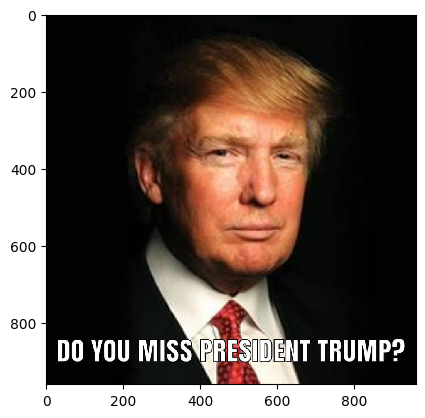

In [117]:
from matplotlib import pyplot as plt
plt.imshow(transformed_image_3, interpolation='nearest')
plt.show()

In [179]:
subtask2b_train = os.listdir("../annotations/subtask2b/subtask2b_images/dev")
images_path = "../annotations/subtask2b/subtask2b_images/val/"

In [162]:
for image_path in subtask2b_train:
    new_images = augment_image_data(images_path + image_path)
    for num, new_image in enumerate(new_images):
        im = Image.fromarray(new_image)
        im.save("augmented_data/val/" + image_path.split(".")[0] + "_" + str(num) + ".png")
